In [2]:
import numpy as np
import numpy.ma as ma
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import scipy
import scipy.stats as stats
import scipy.io as sio
from scipy.optimize import curve_fit
from scipy.stats import norm, gamma
from scipy import signal

import statsmodels.api as sm
import statsmodels.tsa as tsa

from eofs.xarray import Eof

import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature

%matplotlib inline

Problem 1:  PCA and Maximum Covariance Analysis
Under the files menu inside Exam Preparation you will find a file called '552_Midterm2_Set1_2020.mat', which contains two data sets x and y.  They share a sampling dimension of 1024 and have different structure dimensions of 32 and 48.  In all steps, make sure to describe your methods exactly.  Contour plot the raw data at the start and consider.

1.  Do PC/EOF analysis of the two data sets x and y. 
       a) plot the eigenspectra with North uncertainty bars for the two data sets.
       b) plot the first 4 eigenvectors of the two data sets.  Which ones are significant via the North test?
       c) plot the principal components of x and y.  Describe them.  
       d) summarize what you know about the meaningful structures in these two data sets.
2.  Do Maximum Covariance Analysis (MCA) between the two data sets.
       a) Plot the singular value spectrum for the covariance matrix between x and y.  How many singular vector pairs appear to be significant?
       b) Plot the left and right singular vectors, x and y structures obtained from the data.
       c) Plot the heterogeneous regressions of the left and right singular vectors.  That is regress right field onto the PC time series of the left field and vice versa.  What does this tell you? d)  Summarize your conclusions about the relationship between structures in these two data sets as exemplified by their covariance structures.

In [3]:
# load prob 1 data
# load data
fpath = '' # same as current folder
file = './552_Midterm2_Set1_2020.mat'
mat_file = sio.loadmat(fpath + file)
del mat_file['__header__']
del mat_file['__version__']
del mat_file['__globals__']
print(mat_file.keys())
mat_file

dict_keys(['x', 'y'])


{'x': array([[-0.11255 ,  1.0599  ,  0.10956 , ...,  0.67868 , -0.037636,
         -0.37361 ],
        [ 0.32307 ,  0.28217 , -0.060368, ..., -0.29323 , -0.9286  ,
         -0.49503 ],
        [-0.022611,  0.41867 ,  0.13945 , ...,  0.34642 , -1.0267  ,
          0.28706 ],
        ...,
        [-0.70372 , -1.3913  , -0.51499 , ..., -0.5715  ,  0.96647 ,
          0.54689 ],
        [-0.076734, -0.78397 , -1.0305  , ...,  0.28461 ,  0.97976 ,
         -0.40153 ],
        [ 0.11367 , -0.53441 , -1.1585  , ...,  0.90761 ,  0.026083,
         -0.53155 ]]),
 'y': array([[ 0.12096  , -0.28351  ,  0.27203  , ...,  1.8762   ,  0.65762  ,
          0.093194 ],
        [-0.3843   , -0.23848  ,  1.2232   , ...,  0.82995  ,  1.7514   ,
          0.35587  ],
        [-0.23388  , -0.0048265, -0.10113  , ...,  0.64831  ,  1.1798   ,
          0.61611  ],
        ...,
        [-0.87537  , -1.3849   , -0.70319  , ..., -0.42787  , -0.3724   ,
          0.2938   ],
        [-1.0325   , -0.9801   , -1.59

In [113]:
x_unadj = mat_file['x']
y_unadj = mat_file['y']

In [114]:
xda = xr.DataArray(x_unadj, dims=('time','struct'),
                    coords={'time':np.arange(0,1024,1)})
yda = xr.DataArray(y_unadj, dims=('time','struct'),
                    coords={'time':np.arange(0,1024,1)})

## detrended version, aka anomaly matrix
xda = xr.DataArray(signal.detrend(xda,axis=0), dims=('time','struct'),
                    coords={'time':np.arange(0,1024,1)})
yda = xr.DataArray(signal.detrend(yda,axis=0), dims=('time','struct'),
                    coords={'time':np.arange(0,1024,1)})

# create numpy arrays of detrended data
x = np.array(xda)
y = np.array(yda)

nsamp = len(xda.time) 

print(x.shape,y.shape,nsamp)
# print(xda.mean(axis=0))

(1024, 32) (1024, 48) 1024


Text(0.5, 1.0, 'x: raw data')

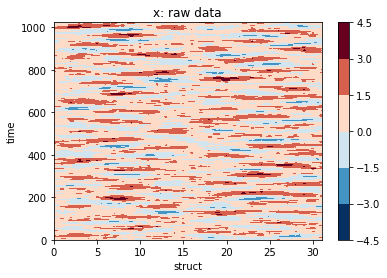

In [115]:
# removed time mean from each structure point
# print(xda.mean(axis=0))
xda.plot.contourf()
plt.title('x: raw data')

Text(0.5, 1.0, 'y: raw data')

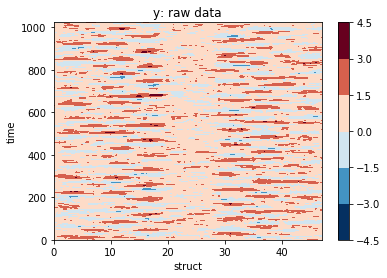

In [116]:
yda.plot.contourf()
plt.title('y: raw data')

In [117]:
# EOF
da = yda # select variable
solver = Eof(da)
eof = solver.eofs(neofs=10)
eof_scale = solver.eofs(neofs=10,eofscaling=2)
eof_corr = solver.eofsAsCorrelation(neofs=10)
pc = solver.pcs(npcs=10, pcscaling=1)
eig = solver.eigenvalues(neigs=10)
varfrac = solver.varianceFraction(neigs=10)

In [118]:
tsa.stattools.acf(pc[:,0],nlags=1,alpha=0.05, fft=True)[0][1]

0.9700465853850806

In [119]:
# autocorrelation estimate
areg = np.zeros(len(da.struct)) # array for autocorrelations at each structure point
aregx = np.zeros(len(xda.struct)) # keeping for MCA later
aregy = np.zeros(len(yda.struct)) # keeping for MCA later

# get 1 lag autocorrelation for d.f.
for i,zero in enumerate(areg):
    areg[i] = tsa.stattools.acf(da[:,i],nlags=1,alpha=0.05, fft=True)[0][1]
for i,zero in enumerate(aregx):
    aregx[i] = tsa.stattools.acf(xda[:,i],nlags=1,alpha=0.05, fft=True)[0][1]
for i,zero in enumerate(aregy):
    aregy[i] = tsa.stattools.acf(yda[:,i],nlags=1,alpha=0.05, fft=True)[0][1]

autox = aregx.mean()
autoy = aregy.mean()

print(areg)
print(areg.min())
print(areg.mean(),aregx.mean(),aregy.mean())
print(areg.max())

[0.40295041 0.59659378 0.73481209 0.75328471 0.74059607 0.69849244
 0.6719101  0.6529186  0.68564243 0.71620058 0.74907813 0.7738913
 0.78892054 0.740704   0.71533749 0.74897086 0.79647998 0.82094441
 0.80890323 0.65815627 0.5025323  0.5061199  0.50336493 0.48458367
 0.45335982 0.46223804 0.48602701 0.4421731  0.48114035 0.65798113
 0.75714735 0.7861949  0.79695254 0.75367271 0.71522849 0.74552173
 0.78780472 0.76059304 0.73850147 0.70910159 0.65287944 0.66136211
 0.60210414 0.63280597 0.71755913 0.72306256 0.71086806 0.52539566]
0.4029504057955293
0.6668971513778222 0.7633801256050418 0.6668971513778222
0.820944409299953


In [10]:
# Bretherton 1999 degrees of freedom for autocorrelation estimate
print(areg.mean())
df = len(da)*(1-(areg.mean())**2)/(1+(areg.mean())**2)
df

0.6668971513778222


393.5445118623898

In [11]:
north = solver.northTest(neigs=10)
north_arr = eig*(np.sqrt(2/df)) # North (1982) standard error

In [12]:
north[0:10]

<xarray.DataArray 'typical_errors' (mode: 10)>
array([0.6427766 , 0.45733477, 0.05507742, 0.05039305, 0.0469485 ,
       0.04324636, 0.04126506, 0.03625779, 0.03432861, 0.031853  ])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9
Attributes:
    long_name:  typical_errors

In [13]:
north_arr

<xarray.DataArray 'eigenvalues' (mode: 10)>
array([1.03684326, 0.73771271, 0.08884371, 0.08128749, 0.07573118,
       0.06975938, 0.06656341, 0.05848633, 0.05537443, 0.05138109])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9

Text(0.5, 1.0, 'Eigenvalue Spectrum')

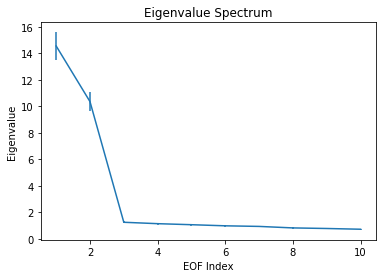

In [14]:
# Plot eigenvalue spectrum with error bars
# this is wrong because it assumes all independent realizations
plt.errorbar(np.arange(1,len(eig)+1),eig,yerr=north_arr,barsabove=True)
plt.ylabel('Eigenvalue')
plt.xlabel('EOF Index')
plt.title('Eigenvalue Spectrum')

<xarray.DataArray 'variance_fractions' ()>
array(0.56929764)


Text(0.5, 1.0, 'Eigenvalue Spectrum: Variance Explained')

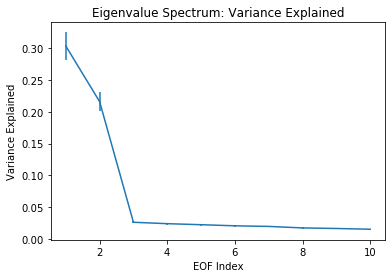

In [15]:
# Plot variance explained with error bars

# scaling uncertainty bars with proportional shortcut, probably is wrong
var_err = (north_arr/eig).mean()*varfrac

print(sum(varfrac[0:4]))
plt.errorbar(np.arange(1,len(eig)+1),varfrac,yerr=var_err,barsabove=True)
plt.ylabel('Variance Explained')
plt.xlabel('EOF Index')
plt.title('Eigenvalue Spectrum: Variance Explained')

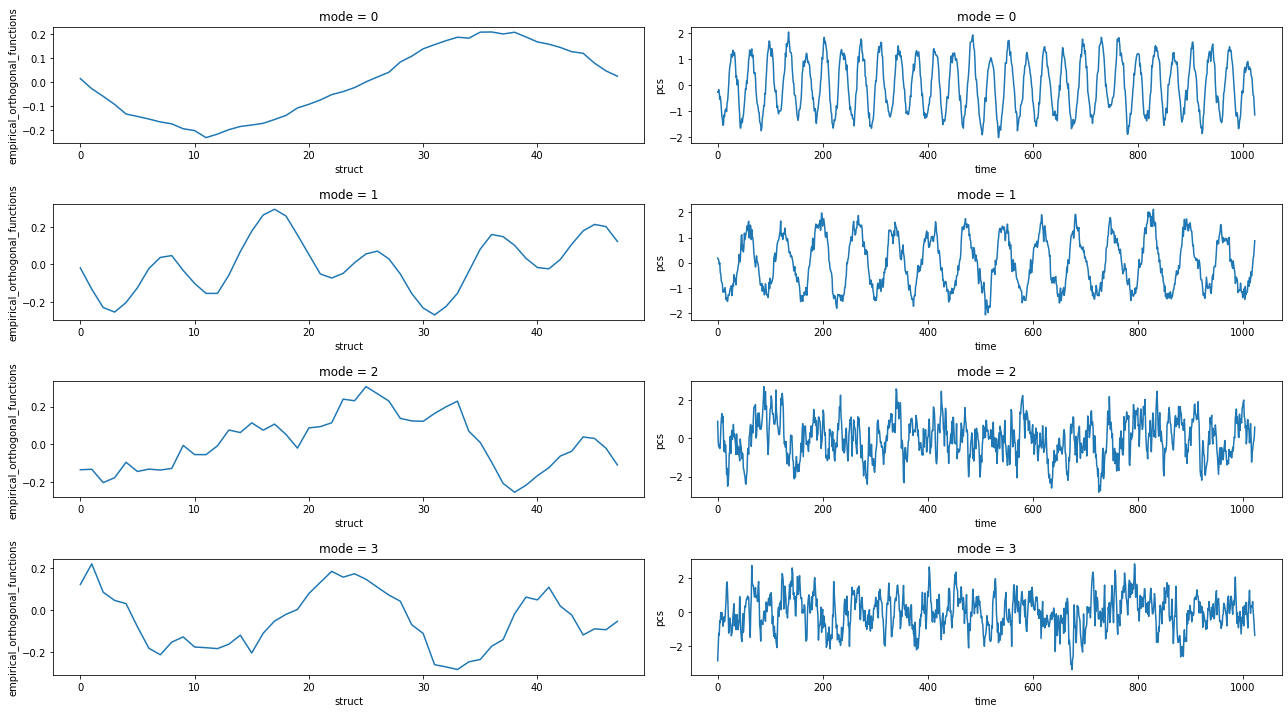

In [16]:
# plot of each EOF and its PC
fig,ax = plt.subplots(nrows=4,ncols=2,figsize=(18,10))


for i in range (0,4):
    plt.xlabel('eof')
    eof[i].plot(ax=ax[i,0])
    pc[:,i].plot(ax=ax[i,1])
    #eof[i,:,:].plot(ax=ax[i,0])

plt.tight_layout()

## Replicate EOF Analysis without package

In [17]:
xmn = np.transpose(x) # xT to be MxN
ymn = np.transpose(y) # yT to be MxN

# standardize x and y bc no knowledge of consistent vars
# already were detrended earlier
xstd = np.zeros(len(xmn[0])*len(xmn)).reshape(len(xmn),len(xmn[0]))
ystd = np.zeros(len(yda.struct)*len(yda.time)).reshape(len(yda.struct),len(yda.time))
print(xstd.shape,ystd.shape)

for i,dummy in enumerate(xda.struct):
    xstd[i] = xmn[i]/(xmn[i].std())
for i,dummy in enumerate(yda.struct):
    ystd[i] = ymn[i]/(ymn[i].std())

(32, 1024) (48, 1024)


In [18]:
# SVD of the MxN matrix where M is structure dim
# i choose to use not standardized for eof

#
datam = ymn # choose variable xmn, xstd, ymn, ystd
#

u,s,vh = np.linalg.svd(datam) 
sdiag = np.diag(s)
u.shape, s.shape, vh.shape

((48, 48), (48,), (1024, 1024))

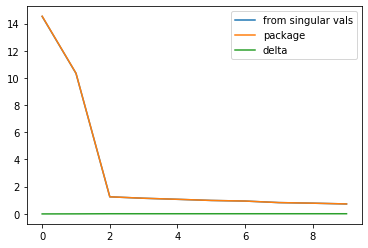

In [19]:
# get eigenvalues from singular values and confirm with package
# singular^2/N = eigenvalue
seig = s**2/nsamp
plt.plot(seig[0:10],label='from singular vals')
plt.plot(eig,label='package')
plt.plot(seig[0:10]-eig,label='delta')
plt.legend()

In [20]:
# get principal components Z = ET * Xmn
z = np.matmul(np.transpose(u),datam)
z.shape

(48, 1024)

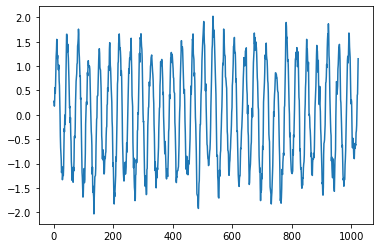

In [21]:
# confirmed that standardized PCs match package output
ztemp = z[0]/(z[0].std())
plt.plot(ztemp)

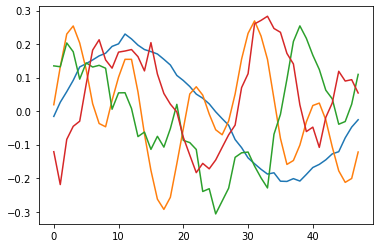

In [22]:
# confirmed that i have the eofs
# eofs are the columns of u
for i in range(0,4):
#     plt.plot(np.transpose(u)[i]*np.sqrt(seig[i])) # scale
    plt.plot(np.transpose(u)[i])

Text(0.5, 0, 'Structure Dimension')

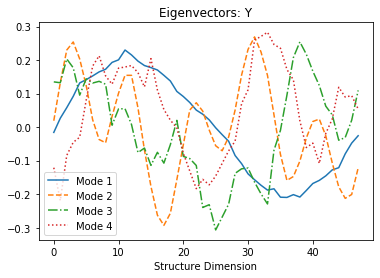

In [23]:
plt.plot(np.transpose(u)[0],linestyle='-',label='Mode 1')
plt.plot(np.transpose(u)[1],linestyle='--',label='Mode 2')
plt.plot(np.transpose(u)[2],linestyle='dashdot',label='Mode 3')
plt.plot(np.transpose(u)[3],linestyle='dotted',label='Mode 4')
plt.legend()
plt.title('Eigenvectors: Y')
plt.xlabel('Structure Dimension')

Text(0.5, 0, 'Structure Dimension')

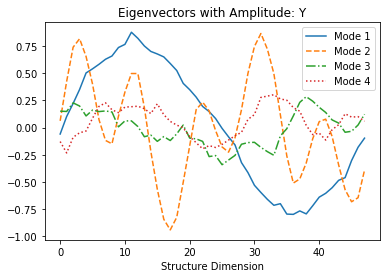

In [24]:
plt.plot(np.transpose(u)[0]*np.sqrt(seig[0]),linestyle='-',label='Mode 1')
plt.plot(np.transpose(u)[1]*np.sqrt(seig[1]),linestyle='--',label='Mode 2')
plt.plot(np.transpose(u)[2]*np.sqrt(seig[2]),linestyle='dashdot',label='Mode 3')
plt.plot(np.transpose(u)[3]*np.sqrt(seig[3]),linestyle='dotted',label='Mode 4')
plt.legend()
plt.title('Eigenvectors with Amplitude: Y')
plt.xlabel('Structure Dimension')

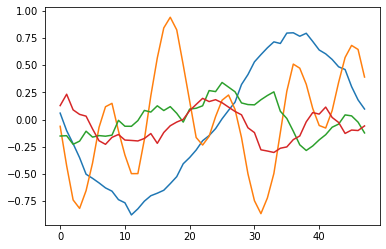

In [25]:
for i in range(0,4):
    plt.plot(eof_scale[i])

In [26]:
# confirm that i can reproduce the original data 
# x = ez
repx = np.matmul(u,z)
print((repx - datam).mean(),(repx - datam).std())

2.3597808514912774e-20 1.2850151369388876e-15


In [27]:
# variance explained
varexpl = np.zeros(len(seig))
varexpl = seig/(seig.sum())
# varexpl

In [28]:
# confirm i can get the north bars
northerr = np.zeros(len(seig))
northerr = seig*np.sqrt(2/df)
northerr_var = northerr/(seig.sum())

Text(0.5, 1.0, 'Eigenvalue Spectrum: Y')

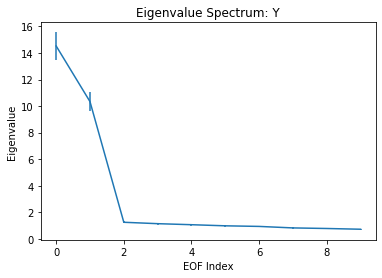

In [29]:
# Plot eigenvalue spectrum with error bars
# i investigated whether these plot the correct error bars and they do
plt.errorbar(np.arange(0,len(seig[0:10])),seig[0:10],yerr=northerr[0:10],barsabove=True)
plt.ylabel('Eigenvalue')
plt.xlabel('EOF Index')
plt.title('Eigenvalue Spectrum: Y')

Text(0.5, 1.0, 'Variance Explained based on Eigenvalue Spectrum: Y')

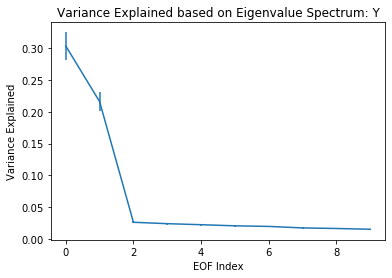

In [30]:
# Plot eigenvalue spectrum variance explained with error bars
plt.errorbar(np.arange(0,len(varexpl[0:10])),varexpl[0:10],yerr=northerr_var[0:10],barsabove=True)
plt.ylabel('Variance Explained')
plt.xlabel('EOF Index')
plt.title('Variance Explained based on Eigenvalue Spectrum: Y')

<xarray.DataArray 'variance_fractions' ()>
array(0.56929764)


Text(0.5, 1.0, 'Eigenvalue Spectrum: Variance Explained')

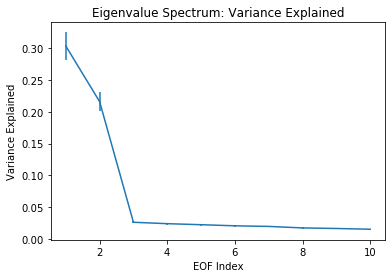

In [31]:
# Plot variance explained with error bars
# this is the wrong EOFs package version
# scaling uncertainty bars with proportional shortcut, probably is wrong
var_err = (north_arr/eig).mean()*varfrac

print(sum(varfrac[0:4]))
plt.errorbar(np.arange(1,len(eig)+1),varfrac,yerr=var_err,barsabove=True)
plt.ylabel('Variance Explained')
plt.xlabel('EOF Index')
plt.title('Eigenvalue Spectrum: Variance Explained')

## Example from Dennis notes

In [32]:
## example
samp = np.array([2,4,-6,8,1,2,-3,4])
samp = samp.reshape(2,4)
samp

array([[ 2,  4, -6,  8],
       [ 1,  2, -3,  4]])

In [33]:
u,s,vh = np.linalg.svd(samp,full_matrices=True)

In [34]:
s=np.diag(np.round(s,6))
s

array([[12.247449,  0.      ],
       [ 0.      ,  0.      ]])

In [35]:
u

array([[-0.89442719, -0.4472136 ],
       [-0.4472136 ,  0.89442719]])

In [36]:
vh.shape

(4, 4)

In [37]:
vh

array([[-0.18257419, -0.36514837,  0.54772256, -0.73029674],
       [-0.97372899,  0.03267096, -0.21567311,  0.06534193],
       [-0.12171612,  0.62908387,  0.72304086,  0.25816774],
       [-0.06085806, -0.68545806,  0.36152043,  0.62908387]])

In [38]:
vh[0:2]

array([[-0.18257419, -0.36514837,  0.54772256, -0.73029674],
       [-0.97372899,  0.03267096, -0.21567311,  0.06534193]])

In [39]:
s.shape

(2, 2)

In [40]:
# create principle components
z = np.matmul(s,vh[0:2])

In [41]:
np.matmul(u,z)

array([[ 2.00000005,  4.00000009, -6.00000014,  8.00000019],
       [ 1.00000002,  2.00000005, -3.00000007,  4.00000009]])

In [42]:
u

array([[-0.89442719, -0.4472136 ],
       [-0.4472136 ,  0.89442719]])

In [43]:
z

array([[-2.23606803, -4.47213606,  6.70820409, -8.94427212],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

## MCA

In [44]:
# standardize x and y bc no knowledge of consistent vars
# already were detrended earlier
xstd = np.zeros(len(xmn[0])*len(xmn)).reshape(len(xmn),len(xmn[0]))
ystd = np.zeros(len(yda.struct)*len(yda.time)).reshape(len(yda.struct),len(yda.time))
print(xstd.shape,ystd.shape)

for i,dummy in enumerate(xda.struct):
    xstd[i] = xmn[i]/(xmn[i].std())
for i,dummy in enumerate(yda.struct):
    ystd[i] = ymn[i]/(ymn[i].std())

(32, 1024) (48, 1024)


In [45]:
# compute covariance matrix of x and yT
cxy = np.matmul(xstd,np.transpose(ystd))/(nsamp-1)
cxy.shape

(32, 48)

In [46]:
uxy,sxy,vhxy = np.linalg.svd(cxy)
print(uxy.shape,sxy.shape,vhxy.shape)

(32, 32) (32,) (48, 48)


In [47]:
# total squared covariance
TSC = (cxy**2).sum()
print(TSC,np.sum(sxy**2)) # sum of sing values should equal TSC

# calculate Normalized Root Mean Squared Covariance
# this is TSC / (var(X)*var(Y)) where variances are at each structure point
RMSC = (TSC/(xstd.var(axis=1).sum() * ystd.var(axis=1).sum()))**(1/2)
print(RMSC) # if >0.1, MCA is good

# d.f., per Dennis MCA example
mca_df = nsamp*(1-autox*autoy)/(1+autox*autoy) # bretherton 1999

# calculate explained covariance % by each mode
## mca_expvar = sxy**2/((sxy**2).sum())
mca_expvar = sxy/((sxy).sum())
print(mca_df,mca_expvar[0:4])

# north bars
mca_northerr = np.zeros(len(sxy))
mca_northerr = sxy*np.sqrt(2/mca_df)
mca_northerr_var = mca_northerr/(sxy.sum())

51.31288926048583 51.31288926048579
0.18277535103407352
333.10382750962714 [0.55695936 0.10796766 0.05438319 0.04353168]


Text(0.5, 1.0, 'Singular Value Spectrum')

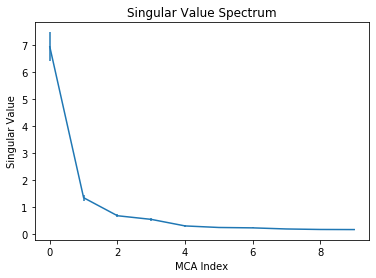

In [53]:
# Plot singular value spectrum with error bars
# i investigated whether these plot the correct error bars and they do
plt.errorbar(np.arange(0,len(sxy[0:10])),sxy[0:10],yerr=mca_northerr[0:10],barsabove=True)
plt.ylabel('Singular Value')
plt.xlabel('MCA Index')
plt.title('Singular Value Spectrum')

Text(0.5, 1.0, 'Singular Spectrum (% of Explained Covariance)')

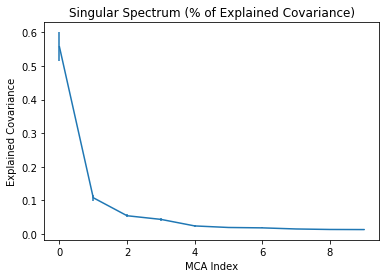

In [54]:
# Plot singular value explained covariance with error bars
plt.errorbar(np.arange(0,len(mca_expvar[0:10])),mca_expvar[0:10],yerr=mca_northerr_var[0:10],barsabove=True)
plt.ylabel('Explained Covariance')
plt.xlabel('MCA Index')
plt.title('Singular Spectrum (% of Explained Covariance)')

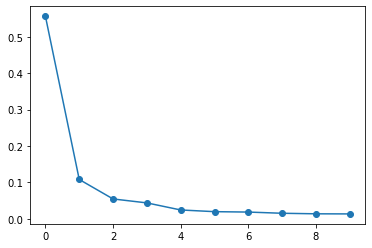

In [49]:
plt.plot(mca_expvar[0:10],marker='o')

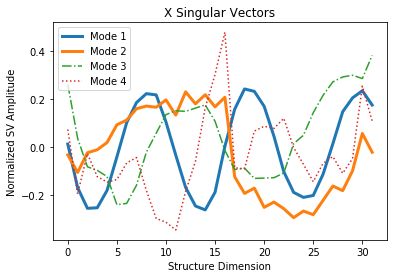

In [66]:
# columns of u are structures in x
plt.plot(np.transpose(uxy)[0],linestyle='-',label='Mode 1',linewidth=3)
plt.plot(np.transpose(uxy)[1],linestyle='-',label='Mode 2',linewidth=3)
plt.plot(np.transpose(uxy)[2],linestyle='dashdot',label='Mode 3')
plt.plot(np.transpose(uxy)[3],linestyle='dotted',label='Mode 4')
plt.legend()
plt.title('X Singular Vectors')
plt.xlabel('Structure Dimension')
plt.ylabel('Normalized SV Amplitude')
plt.show()

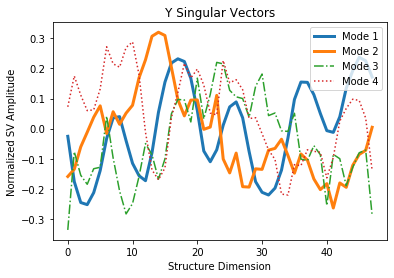

In [67]:
# columns of v are structures in y
plt.plot(vhxy[0],linestyle='-',label='Mode 1',linewidth=3)
plt.plot(vhxy[1],linestyle='-',label='Mode 2',linewidth=3)
plt.plot(vhxy[2],linestyle='dashdot',label='Mode 3')
plt.plot(vhxy[3],linestyle='dotted',label='Mode 4')
plt.legend()
plt.title('Y Singular Vectors')
plt.xlabel('Structure Dimension')
plt.ylabel('Normalized SV Amplitude')
plt.show()

In [63]:
## project onto data to get expansion coefs, ie "PCs" for MCA
xstar = np.matmul(np.transpose(uxy),xmn)
ystar = np.matmul(vhxy,ymn)
print(xstar.shape,ystar.shape)

(32, 1024) (48, 1024)


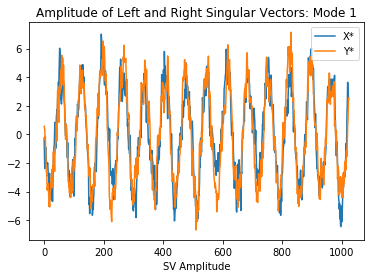

In [78]:
# check plot of expansion coefficients
plt.plot(xstar[0], label='X*')
plt.plot(ystar[0], label='Y*')
plt.title('Amplitude of Left and Right Singular Vectors: Mode 1')
plt.xlabel('SV Amplitude')
plt.legend(loc=1)

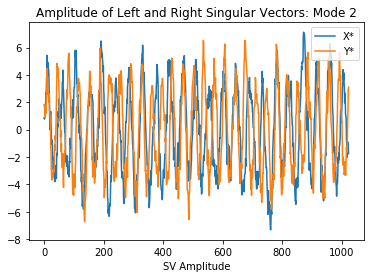

In [79]:
# check plot of expansion coefficients
plt.plot(xstar[1], label='X*')
plt.plot(ystar[1], label='Y*')
plt.title('Amplitude of Left and Right Singular Vectors: Mode 2')
plt.xlabel('SV Amplitude')
plt.legend(loc=1)

In [81]:
# create standardized loading vectors
xtilde = xstar.copy()
ytilde = ystar.copy()
print(xtilde.shape,ytilde.shape)

for i,dummy in enumerate(xda.struct):
    xtilde[i] = xstar[i]/(xstar[i].std())
for i,dummy in enumerate(yda.struct):
    ytilde[i] = ystar[i]/(ystar[i].std())

(32, 1024) (48, 1024)


In [82]:
# create heterogenous regressions
# per Hartmann Barnes (5.60) in book
Dxy = np.matmul(xmn,np.transpose(ytilde))/nsamp
Dyx = np.matmul(ymn,np.transpose(xtilde))/nsamp

Dxx = np.matmul(xmn,np.transpose(xtilde))/nsamp
Dyy = np.matmul(ymn,np.transpose(ytilde))/nsamp

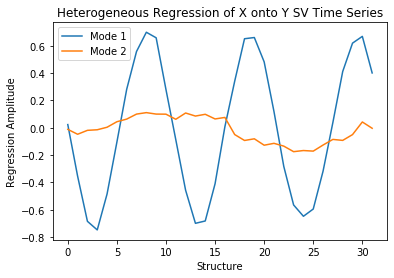

In [87]:
# Plot of heterogeneous, homogeneous regression and pattern
plt.title('Heterogeneous Regression of X onto Y SV Time Series')
plt.ylabel('Regression Amplitude')
plt.xlabel('Structure')
plt.plot(np.transpose(Dxy)[0],label='Mode 1')
plt.plot(np.transpose(Dxy)[1],label='Mode 2')
plt.legend()
# plt.plot(np.transpose(uxy)[0],label='Normalized SV Amplitude')
#plt.plot(np.transpose(Dxx)[0])

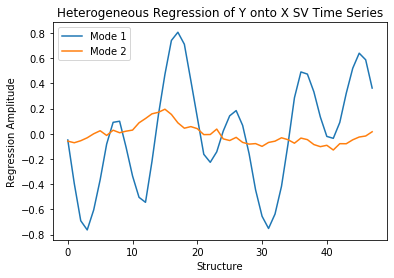

In [88]:
# Plot of heterogeneous, homogeneous regression and pattern
plt.title('Heterogeneous Regression of Y onto X SV Time Series')
plt.ylabel('Regression Amplitude')
plt.xlabel('Structure')
plt.plot(np.transpose(Dyx)[0],label='Mode 1')
plt.plot(np.transpose(Dyx)[1],label='Mode 2')
plt.legend()
# plt.plot(np.transpose(uxy)[0],label='Normalized SV Amplitude')
#plt.plot(np.transpose(Dxx)[0])

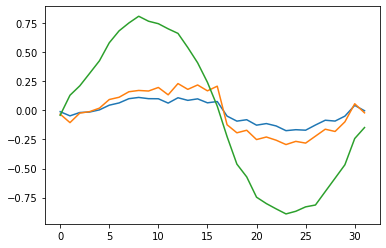

In [97]:
# Plot of heterogeneous, homogeneous regression and pattern
plt.plot(np.transpose(Dxy)[1])
plt.plot(np.transpose(uxy)[1])
plt.plot(np.transpose(Dxx)[1])

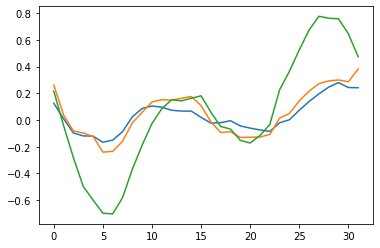

In [98]:
# Plot of heterogeneous, homogeneous regression and pattern
plt.plot(np.transpose(Dxy)[2])
plt.plot(np.transpose(uxy)[2])
plt.plot(np.transpose(Dxx)[2])

## Problem 2

In [4]:
# load prob 2 data
# load data
fpath = '' # same as current folder
file = '552_Dat_2_2020.mat'
mat_file = sio.loadmat(fpath + file)
del mat_file['__header__']
del mat_file['__version__']
del mat_file['__globals__']
print(mat_file.keys())
#mat_file

dict_keys(['x552csp', 'y552csp'])


In [5]:
x2_unadj = mat_file['x552csp'].squeeze()
y2_unadj = mat_file['y552csp'].squeeze()

N = len(y2_unadj)
N

4096

Text(0.5, 1.0, 'X (Unadjusted)')

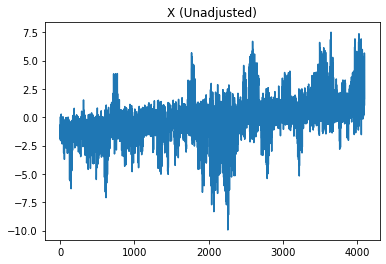

In [6]:
plt.plot(x2_unadj)
plt.title('X (Unadjusted)')

Text(0.5, 1.0, 'Y (Unadjusted)')

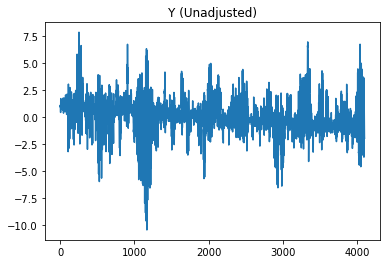

In [32]:
plt.plot(y2_unadj)
plt.title('Y (Unadjusted)')

Text(0.5, 1.0, 'X (Detrended)')

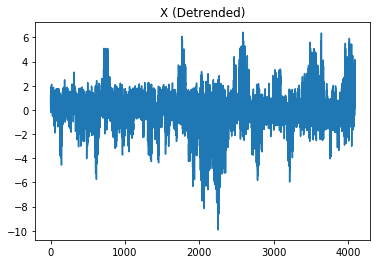

In [9]:
x2 = signal.detrend(x2_unadj)
y2 = signal.detrend(y2_unadj)
plt.plot(x2)
plt.title('X (Detrended)')

Text(0.5, 1.0, 'Y (Detrended)')

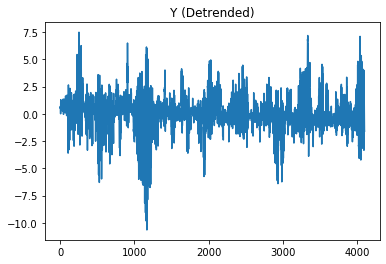

In [10]:
plt.plot(y2)
plt.title('Y (Detrended)')

## WOSA

In [71]:
# choose data for WOSA analysis
data = np.array(x2)
data_unadj = np.array(x2_unadj)
data1 = data[0:(len(data)//2)]
data2 = data[(len(data)//2):]
print(len(data),len(data1),len(data2))

4096 2048 2048


In [72]:
fs = 1 # sampling frequency, determines nyquist max freq by fs/2
window = 'hann'
M = 2**7 # always use power of two #this is chunklength M
noverlap = M // 2
df = N/(M/2)*1.2-1 # Nobs / nspectralestimates=M/2; could multiple by 1-1.5 or 1.2 for hann window

# full data
freq, Psd = signal.welch(data, fs=fs, window=window,
                               nperseg=M, #noverlap=noverlap,
                               scaling='density')

# first half of data
freq1, Psd1 = signal.welch(data1, fs=fs, window=window,
                               nperseg=M, #noverlap=noverlap,
                               scaling='density')

# second half of data
freq2, Psd2 = signal.welch(data2, fs=fs, window=window,
                               nperseg=M, #noverlap=noverlap,
                               scaling='density')


print(df,M)

75.8 128


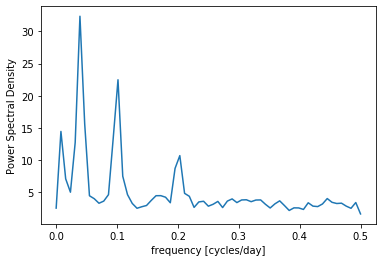

In [73]:
plt.plot(freq, Psd)
# plt.plot(freq1, Psd1)
# plt.plot(freq2, Psd2)
plt.xlabel('frequency [cycles/day]')
plt.ylabel('Power Spectral Density')
plt.show()

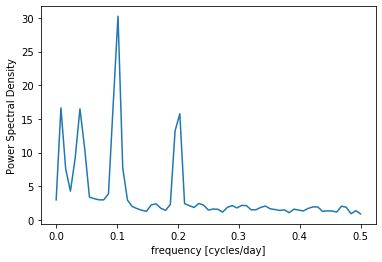

In [216]:
# plt.plot(freq, Psd)
plt.plot(freq1, Psd1)
# plt.plot(freq2, Psd2)
plt.xlabel('frequency [cycles/day]')
plt.ylabel('Power Spectral Density')
plt.show()

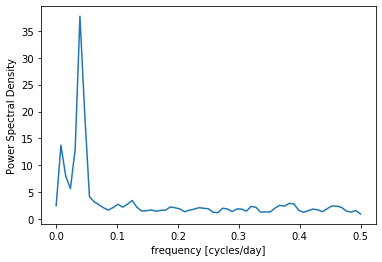

In [167]:
# plt.plot(freq, Psd)
# plt.plot(freq1, Psd1)
plt.plot(freq2, Psd2)
plt.xlabel('frequency [cycles/day]')
plt.ylabel('Power Spectral Density')
plt.show()

In [168]:
1/freq[1:]

array([128.        ,  64.        ,  42.66666667,  32.        ,
        25.6       ,  21.33333333,  18.28571429,  16.        ,
        14.22222222,  12.8       ,  11.63636364,  10.66666667,
         9.84615385,   9.14285714,   8.53333333,   8.        ,
         7.52941176,   7.11111111,   6.73684211,   6.4       ,
         6.0952381 ,   5.81818182,   5.56521739,   5.33333333,
         5.12      ,   4.92307692,   4.74074074,   4.57142857,
         4.4137931 ,   4.26666667,   4.12903226,   4.        ,
         3.87878788,   3.76470588,   3.65714286,   3.55555556,
         3.45945946,   3.36842105,   3.28205128,   3.2       ,
         3.12195122,   3.04761905,   2.97674419,   2.90909091,
         2.84444444,   2.7826087 ,   2.72340426,   2.66666667,
         2.6122449 ,   2.56      ,   2.50980392,   2.46153846,
         2.41509434,   2.37037037,   2.32727273,   2.28571429,
         2.24561404,   2.20689655,   2.16949153,   2.13333333,
         2.09836066,   2.06451613,   2.03174603,   2.  

0.5426639819053163 0.5524599678941117 0.5345331051418866


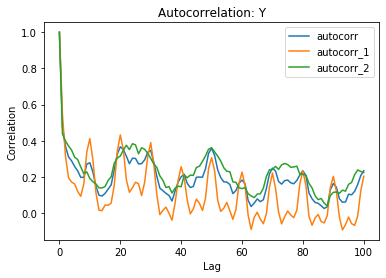

In [59]:
# autocorrelation estimates
areg,confdummy = tsa.stattools.acf(data,nlags=100,alpha=0.05, fft=True)
areg1,confdummy = tsa.stattools.acf(data1,nlags=100,alpha=0.05, fft=True)
areg2,confdummy = tsa.stattools.acf(data2,nlags=100,alpha=0.05, fft=True)

# hartmann barnes p121
# estimate autocorr for red noise by avg of one lag and sqrt of two lag
auto = (areg[1]+np.sqrt(areg[2]))/2
auto1 = (areg1[1]+np.sqrt(areg1[2]))/2
auto2 = (areg2[1]+np.sqrt(areg2[2]))/2

print(auto,auto1,auto2)
plt.plot(areg, label='autocorr')
plt.plot(areg1, label='autocorr_1')
plt.plot(areg2, label='autocorr_2')
# plt.plot(np.linspace(0,len(areg),len(areg)),np.ones(len(areg))/np.exp(1), label='e-fold')
plt.title('Autocorrelation: Y')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()

In [60]:
# keep simple d.f. per Dennis
autocorr_df = N/2 - 1
autocorr_df12 = N/2/2 - 1
print(N, autocorr_df,autocorr_df12)

4096 2047.0 1023.0


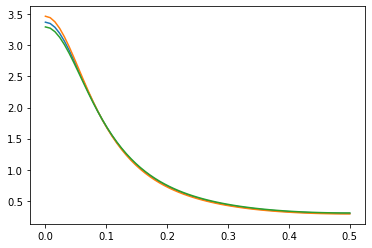

In [61]:
freq_dummy = np.linspace(0,np.pi,len(freq)) # dummy inputs that are same length as freq
red = (1-auto**2)/(1-2*auto*np.cos(freq_dummy*1)+auto**2) # red noise shape factor
red1 = (1-auto1**2)/(1-2*auto1*np.cos(freq_dummy*1)+auto1**2) # red noise shape factor
red2 = (1-auto2**2)/(1-2*auto2*np.cos(freq_dummy*1)+auto2**2) # red noise shape factor
plt.plot(freq,red)
plt.plot(freq,red1)
plt.plot(freq,red2)
#plt.ylim(0,6)
# plt.xlim(0,.1)?

In [62]:
# this ratio works because i used same number of data points for red and freq
# this shows up above in choice of freq_dummy
redadj = np.sum(Psd)/np.sum(red)*red
redadj1 = np.sum(Psd1)/np.sum(red1)*red1
redadj2 = np.sum(Psd2)/np.sum(red2)*red2

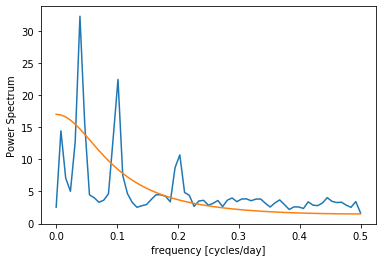

In [63]:
plt.plot(freq, Psd)
plt.plot(freq, redadj)
#plt.ylim([0.5e-3, 1])
# plt.xlim(0, .1)
plt.xlabel('frequency [cycles/day]')
plt.ylabel('Power Spectrum')
plt.show()

In [64]:
# find red noise line with 95% confidence interval with a priori reason to believe each orbital peak
clevel = 0.95
conf = stats.f.ppf(clevel,df,autocorr_df) # f stat 
conf12 = stats.f.ppf(clevel,df,autocorr_df12) # f stat 
chanceoccurence = clevel**(M/2/1.2) # true a posteriori confidence level
print(conf, clevel, chanceoccurence)

1.2885879742579232 0.95 0.06485233469933027


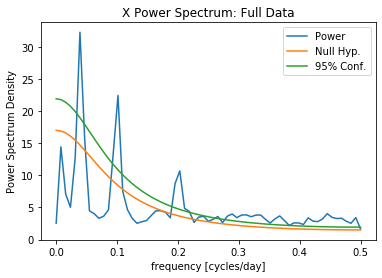

In [74]:
# X VERSION
# plot with confidence interval
plt.plot(freq, Psd, linestyle='-', label='Power')
plt.plot(freq, redadj, label='Null Hyp.')
plt.plot(freq,redadj*conf, label='95% Conf.')
# plt.xlim([0, .1])
plt.xlabel('frequency [cycles/day]')
plt.ylabel('Power Spectrum Density')
plt.title('X Power Spectrum: Full Data')
plt.legend()
plt.show()

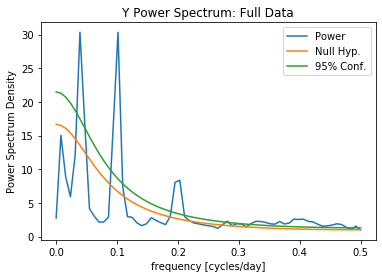

In [179]:
# Y VERSION
# plot with confidence interval
plt.plot(freq, Psd, linestyle='-', label='Power')
plt.plot(freq, redadj, label='Null Hyp.')
plt.plot(freq,redadj*conf, label='95% Conf.')
# plt.xlim([0, .1])
plt.xlabel('frequency [cycles/day]')
plt.ylabel('Power Spectrum Density')
plt.title('Y Power Spectrum: Full Data')
plt.legend()
plt.show()

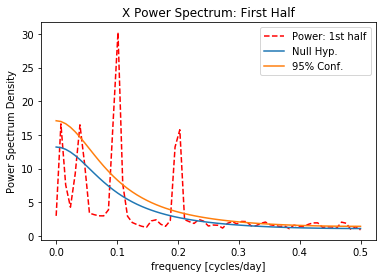

In [224]:
# X VERSION
# plot with confidence interval # first half
plt.plot(freq, Psd1,c='r', linestyle='--',label='Power: 1st half')
plt.plot(freq, redadj1, label='Null Hyp.')
plt.plot(freq,redadj1*conf12, label='95% Conf.')
# plt.xlim([0, .1])
plt.xlabel('frequency [cycles/day]')
plt.ylabel('Power Spectrum Density')
plt.title('X Power Spectrum: First Half')
plt.legend()
plt.show()

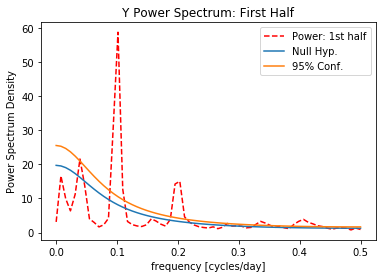

In [180]:
# Y VERSION
# plot with confidence interval # first half
plt.plot(freq, Psd1,c='r', linestyle='--',label='Power: 1st half')
plt.plot(freq, redadj1, label='Null Hyp.')
plt.plot(freq,redadj1*conf12, label='95% Conf.')
# plt.xlim([0, .1])
plt.xlabel('frequency [cycles/day]')
plt.ylabel('Power Spectrum Density')
plt.title('Y Power Spectrum: First Half')
plt.legend()
plt.show()

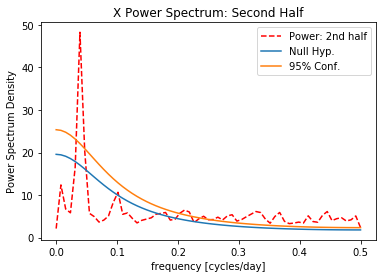

In [225]:
# X VERSION
# plot with confidence interval # second half
plt.plot(freq, Psd2,c='r', linestyle='--',label='Power: 2nd half')
plt.plot(freq, redadj2, label='Null Hyp.')
plt.plot(freq,redadj2*conf12, label='95% Conf.')
# plt.xlim([0, .1])
plt.xlabel('frequency [cycles/day]')
plt.ylabel('Power Spectrum Density')
plt.title('X Power Spectrum: Second Half')
plt.legend()
plt.show()

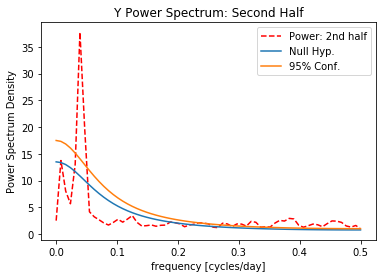

In [181]:
# Y VERSION
# plot with confidence interval # second half
plt.plot(freq, Psd2,c='r', linestyle='--',label='Power: 2nd half')
plt.plot(freq, redadj2, label='Null Hyp.')
plt.plot(freq,redadj2*conf12, label='95% Conf.')
# plt.xlim([0, .1])
plt.xlabel('frequency [cycles/day]')
plt.ylabel('Power Spectrum Density')
plt.title('Y Power Spectrum: Second Half')
plt.legend()
plt.show()

(0, 0.25)

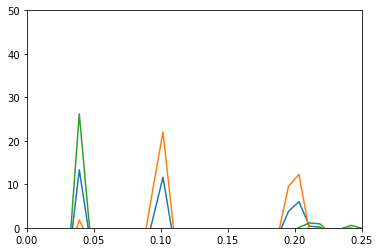

In [226]:
# significant peaks # X
plt.plot(freq,Psd-redadj*conf)
plt.plot(freq1,Psd1-redadj1*conf12)
plt.plot(freq2,Psd2-redadj2*conf12)
plt.ylim(0,50)
plt.xlim(0,.25)

(0, 0.25)

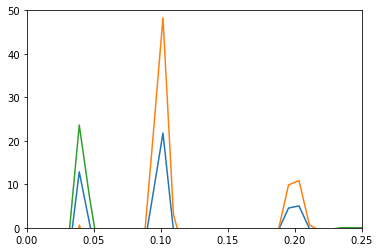

In [182]:
# significant peaks # Y
plt.plot(freq,Psd-redadj*conf)
plt.plot(freq1,Psd1-redadj1*conf12)
plt.plot(freq2,Psd2-redadj2*conf12)
plt.ylim(0,50)
plt.xlim(0,.25)

In [227]:
# significant full data
print(np.where(Psd==Psd.max()))
print(np.where(Psd-redadj*conf>0))
print(1/freq[np.where(Psd-redadj*conf>0)])

(array([5]),)
(array([ 5, 12, 13, 25, 26, 27, 28, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44,
       45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
       62, 63]),)
[25.6        10.66666667  9.84615385  5.12        4.92307692  4.74074074
  4.57142857  3.76470588  3.55555556  3.45945946  3.36842105  3.28205128
  3.2         3.12195122  3.04761905  2.97674419  2.90909091  2.84444444
  2.7826087   2.72340426  2.66666667  2.6122449   2.56        2.50980392
  2.46153846  2.41509434  2.37037037  2.32727273  2.28571429  2.24561404
  2.20689655  2.16949153  2.13333333  2.09836066  2.06451613  2.03174603]


In [228]:
# significant first half data
print(np.where(Psd1-redadj1*conf12>0))
print(1/freq[np.where(Psd1-redadj1*conf12>0)])

(array([ 5, 12, 13, 14, 25, 26, 39, 40, 43, 44, 50, 53, 54, 55, 60, 61]),)
[25.6        10.66666667  9.84615385  9.14285714  5.12        4.92307692
  3.28205128  3.2         2.97674419  2.90909091  2.56        2.41509434
  2.37037037  2.32727273  2.13333333  2.09836066]


In [229]:
# significant second half data
print(np.where(Psd2-redadj2*conf12>1))
print(1/freq[np.where(Psd2-redadj2*conf12>1)])

(array([ 5, 27, 36, 37, 40, 41, 42, 43, 44, 46, 47, 48, 51, 53, 54, 55, 56,
       57, 58, 59, 60, 61, 62, 63]),)
[25.6         4.74074074  3.55555556  3.45945946  3.2         3.12195122
  3.04761905  2.97674419  2.90909091  2.7826087   2.72340426  2.66666667
  2.50980392  2.41509434  2.37037037  2.32727273  2.28571429  2.24561404
  2.20689655  2.16949153  2.13333333  2.09836066  2.06451613  2.03174603]


In [192]:
1/bw

128.0

## Filtering

In [14]:
# get bandwidth, freqs, etc
bw = freq[1] - freq[0]
print(bw)
nyq = 1/(2*fs) # nyquist 1/(2*timestep)
select_freq = np.array([1/25,1/10,1/5])
periods = 1/select_freq
wn = select_freq/nyq
print(select_freq,wn,periods)

0.0078125
[0.04 0.1  0.2 ] [0.08 0.2  0.4 ] [25. 10.  5.]


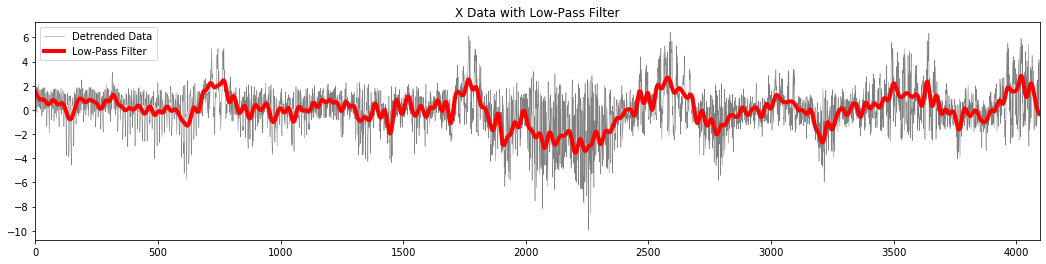

In [65]:
# X low pass filter; everything lower than one bw away from 25 day
b, a = signal.butter(16, wn[0]-1*bw/nyq, btype='low')
wlow, hlow = signal.freqz(b,a)
outlow = signal.filtfilt(b,a,data)
fig, ax = plt.subplots(figsize=(18,4))
plt.plot(data,linewidth=0.5,label='Detrended Data',c='grey')
plt.plot(outlow,linewidth=4,label='Low-Pass Filter',c='r')
plt.xlim(0,N)
plt.legend()
plt.title('X Data with Low-Pass Filter')
plt.show()

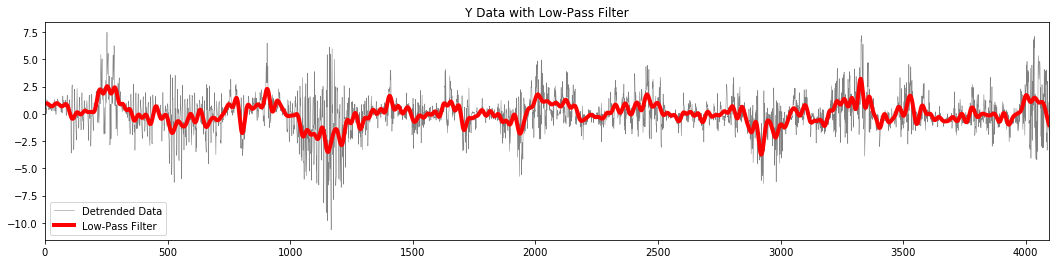

In [15]:
# Y low pass filter; everything lower than one bw away from 25 day
b, a = signal.butter(16, wn[0]-1*bw/nyq, btype='low')
wlow, hlow = signal.freqz(b,a)
outlow = signal.filtfilt(b,a,data)
fig, ax = plt.subplots(figsize=(18,4))
plt.plot(data,linewidth=0.5,label='Detrended Data',c='grey')
plt.plot(outlow,linewidth=4,label='Low-Pass Filter',c='r')
plt.xlim(0,N)
plt.legend()
plt.title('Y Data with Low-Pass Filter')
plt.show()

(0, 4096)

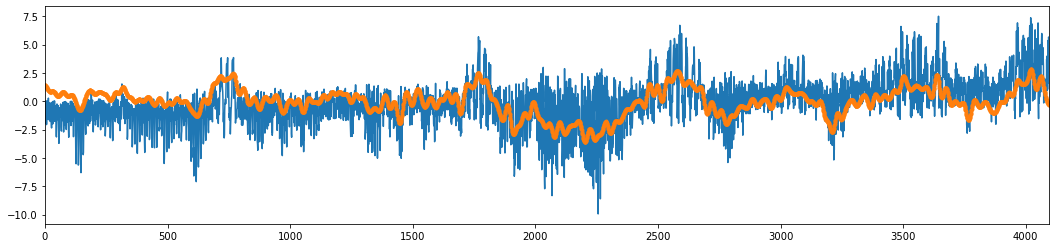

In [232]:
# unadjusted data
fig, ax = plt.subplots(figsize=(18,4))
plt.plot(data_unadj)
plt.plot(outlow,marker='.')
plt.xlim(0,N)

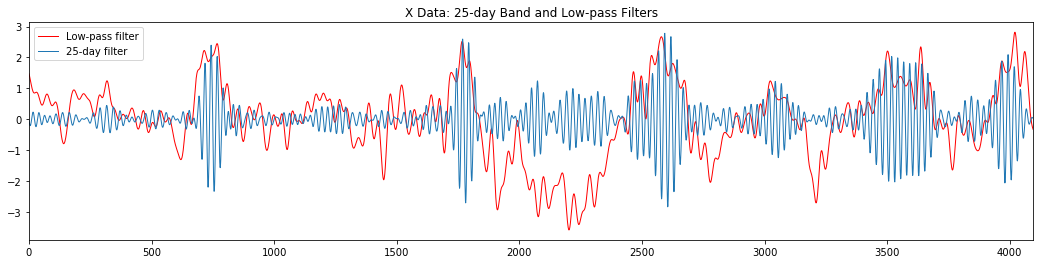

In [66]:
# band pass filter - 25 - X
b, a = signal.butter(7, [wn[0]-bw/nyq, wn[0]+bw/nyq], btype='band')
w25, h25 = signal.freqz(b,a)
out25 = signal.filtfilt(b,a,data)
fig, ax = plt.subplots(figsize=(18,4))
# plt.plot(data)
plt.plot(outlow,linewidth=1,c='r',label='Low-pass filter')
plt.plot(out25,linewidth=1,label='25-day filter')
plt.xlim(0,N)
plt.legend()
plt.title('X Data: 25-day Band and Low-pass Filters')
plt.show()

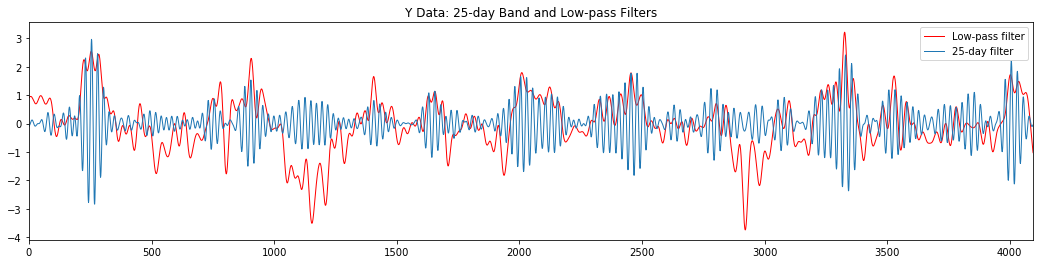

In [16]:
# band pass filter - 25 - Y 
b, a = signal.butter(7, [wn[0]-bw/nyq, wn[0]+bw/nyq], btype='band')
w25, h25 = signal.freqz(b,a)
out25 = signal.filtfilt(b,a,data)
fig, ax = plt.subplots(figsize=(18,4))
# plt.plot(data)
plt.plot(outlow,linewidth=1,c='r',label='Low-pass filter')
plt.plot(out25,linewidth=1,label='25-day filter')
plt.xlim(0,N)
plt.legend()
plt.title('Y Data: 25-day Band and Low-pass Filters')
plt.show()

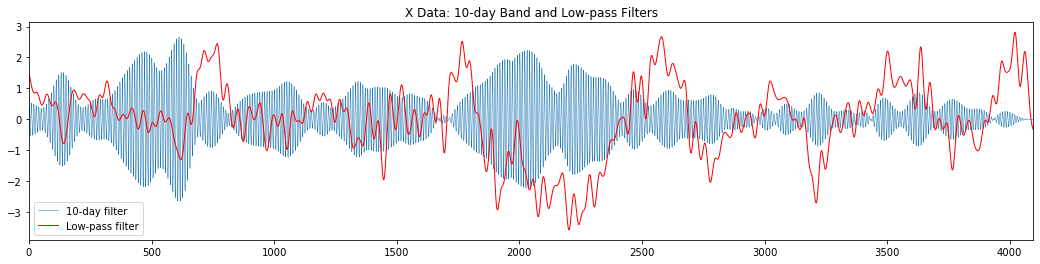

In [67]:
# band pass filter - 10 - X
b, a = signal.butter(9, [wn[1]-bw/nyq, wn[1]+bw/nyq], btype='band')
w10, h10 = signal.freqz(b,a)
out10 = signal.filtfilt(b,a,data)
fig, ax = plt.subplots(figsize=(18,4))
plt.plot(out10,linewidth=0.5,label='10-day filter')
plt.plot(outlow,linewidth=1,c='r',label='Low-pass filter')
plt.xlim(0,N)
plt.legend()
plt.title('X Data: 10-day Band and Low-pass Filters')
plt.show()

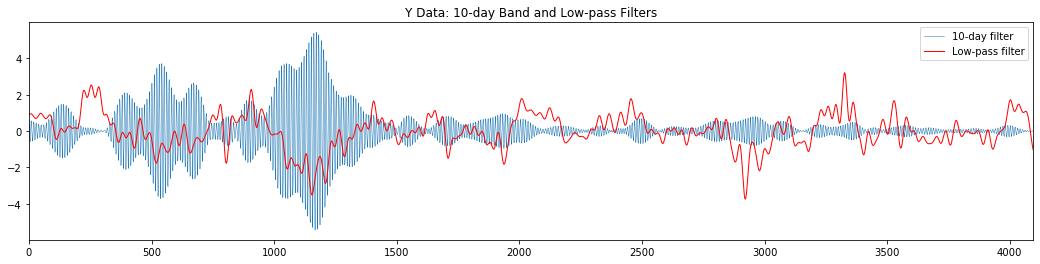

In [17]:
# band pass filter - 10 - Y
b, a = signal.butter(9, [wn[1]-bw/nyq, wn[1]+bw/nyq], btype='band')
w10, h10 = signal.freqz(b,a)
out10 = signal.filtfilt(b,a,data)
fig, ax = plt.subplots(figsize=(18,4))
plt.plot(out10,linewidth=0.5,label='10-day filter')
plt.plot(outlow,linewidth=1,c='r',label='Low-pass filter')
plt.xlim(0,N)
plt.legend()
plt.title('Y Data: 10-day Band and Low-pass Filters')
plt.show()

(0, 4096)

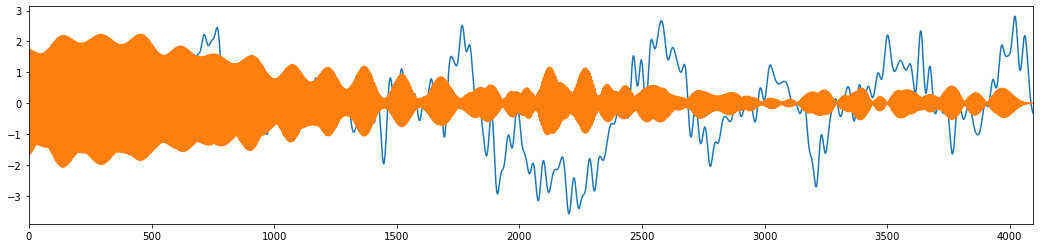

In [376]:
# band pass filter - 5
b, a = signal.butter(11, [wn[2]-bw/nyq, wn[2]+bw/nyq], btype='band')
w5, h5 = signal.freqz(b,a)
out5 = signal.filtfilt(b,a,data)
fig, ax = plt.subplots(figsize=(18,4))
# plt.plot(data)
plt.plot(outlow)
plt.plot(out5)
plt.xlim(0,N)

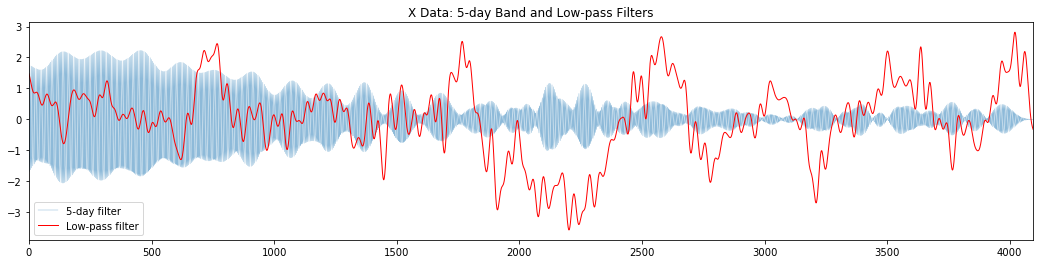

In [68]:
# band pass filter - 5 - X
b, a = signal.butter(11, [wn[2]-bw/nyq, wn[2]+bw/nyq], btype='band')
w5, h5 = signal.freqz(b,a)
out5 = signal.filtfilt(b,a,data)
fig, ax = plt.subplots(figsize=(18,4))
plt.plot(out5,linewidth=0.25,label='5-day filter')
plt.plot(outlow,linewidth=1,c='r',label='Low-pass filter')
plt.xlim(0,N)
plt.legend()
plt.title('X Data: 5-day Band and Low-pass Filters')
plt.show()

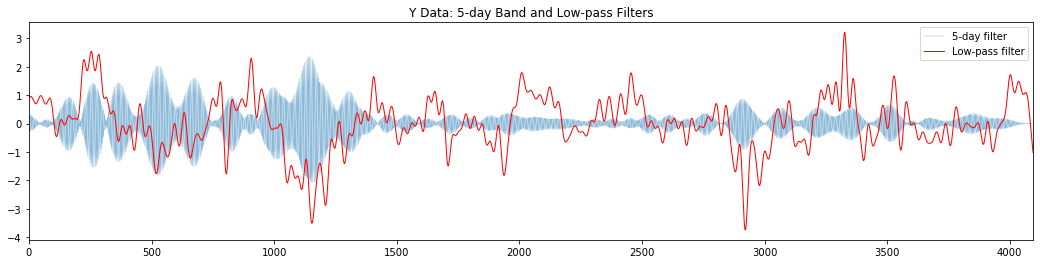

In [18]:
# band pass filter - 5 - Y
b, a = signal.butter(11, [wn[2]-bw/nyq, wn[2]+bw/nyq], btype='band')
w5, h5 = signal.freqz(b,a)
out5 = signal.filtfilt(b,a,data)
fig, ax = plt.subplots(figsize=(18,4))
plt.plot(out5,linewidth=0.25,label='5-day filter')
plt.plot(outlow,linewidth=1,c='r',label='Low-pass filter')
plt.xlim(0,N)
plt.legend()
plt.title('Y Data: 5-day Band and Low-pass Filters')
plt.show()

### Y VERSION

(0, 4096)

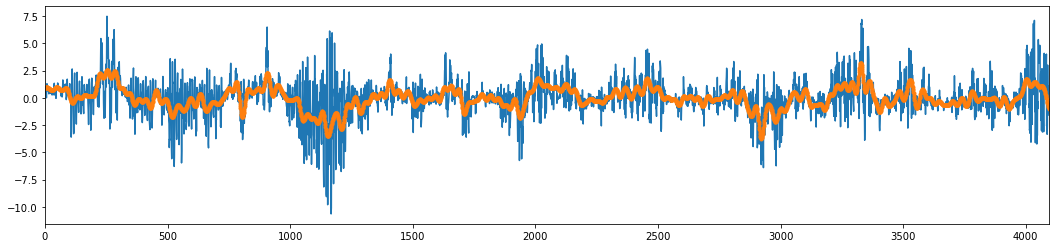

In [88]:
# low pass filter; everything lower than one bw away from 25 day
b, a = signal.butter(16, wn[0]-1*bw/nyq, btype='low')
wlow, hlow = signal.freqz(b,a)
outlow = signal.filtfilt(b,a,data)
fig, ax = plt.subplots(figsize=(18,4))
plt.plot(data)
plt.plot(outlow,marker='.')
plt.xlim(0,N)

(0, 4096)

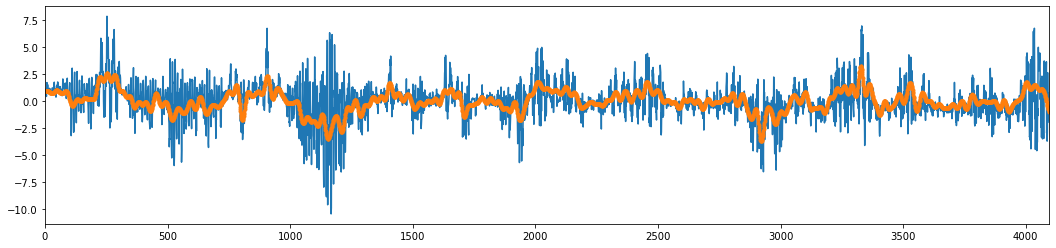

In [397]:
# unadjusted data
fig, ax = plt.subplots(figsize=(18,4))
plt.plot(y2_unadj)
plt.plot(outlow,marker='.')
plt.xlim(0,N)

(0, 4096)

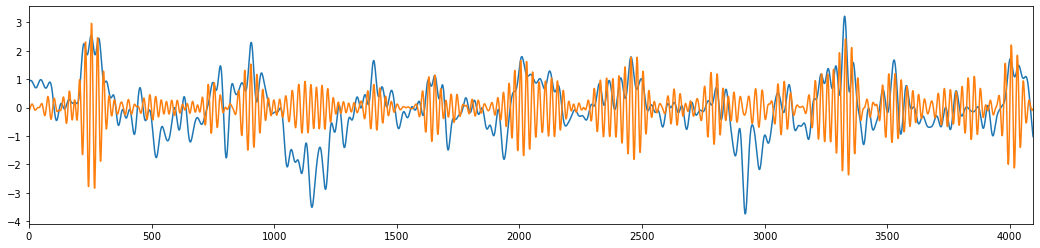

In [89]:
# band pass filter - 25
b, a = signal.butter(7, [wn[0]-bw/nyq, wn[0]+bw/nyq], btype='band')
w25, h25 = signal.freqz(b,a)
out25 = signal.filtfilt(b,a,data)
fig, ax = plt.subplots(figsize=(18,4))
# plt.plot(data)
plt.plot(outlow)
plt.plot(out25)
plt.xlim(0,N)

(0, 4096)

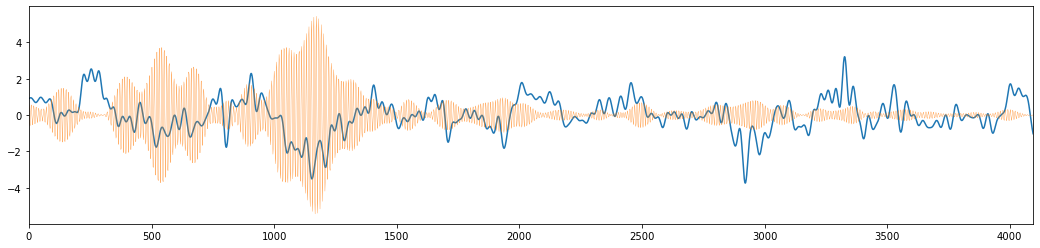

In [418]:
# band pass filter - 10
b, a = signal.butter(9, [wn[1]-bw/nyq, wn[1]+bw/nyq], btype='band')
w10, h10 = signal.freqz(b,a)
out10 = signal.filtfilt(b,a,data)
fig, ax = plt.subplots(figsize=(18,4))
# plt.plot(data)
plt.plot(outlow)
plt.plot(out10,linewidth=0.3)
plt.xlim(0,N)

(0, 4096)

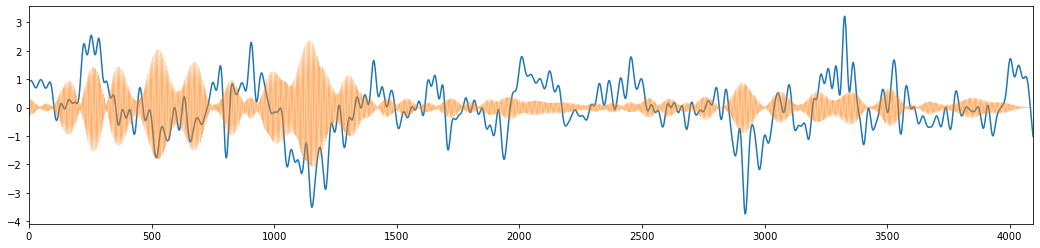

In [417]:
# band pass filter - 5
b, a = signal.butter(11, [wn[2]-bw/nyq, wn[2]+bw/nyq], btype='band')
w5, h5 = signal.freqz(b,a)
out5 = signal.filtfilt(b,a,data)
fig, ax = plt.subplots(figsize=(18,4))
# plt.plot(data)
plt.plot(outlow)
plt.plot(out5,linewidth='0.3')
plt.xlim(0,N)

## Relationship between band and low

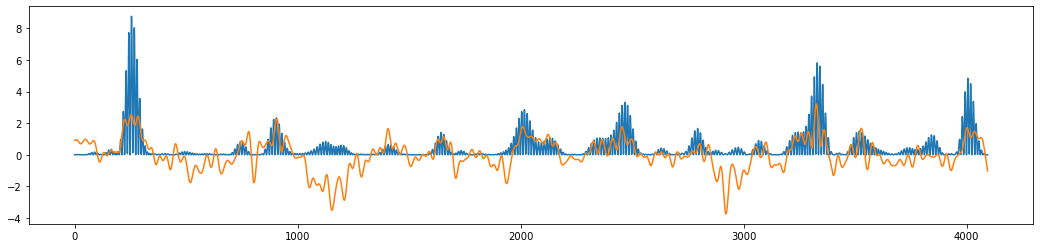

In [440]:
fig, ax = plt.subplots(figsize=(18,4))
#plt.plot(np.abs((outlow)))
plt.plot((out25**2))
plt.plot(outlow)

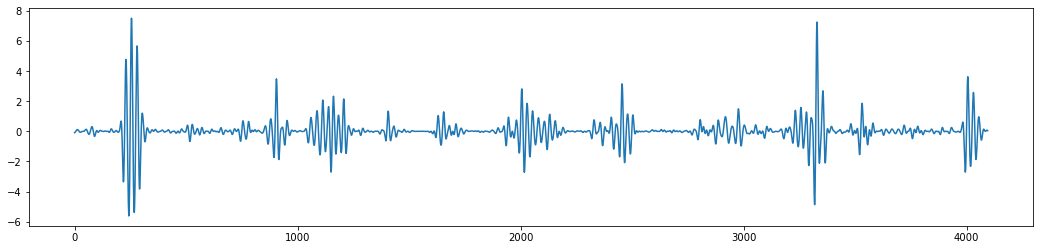

In [419]:
fig, ax = plt.subplots(figsize=(18,4))
plt.plot(outlow*out25)

(0.4590358986336381, 1.1815766386139888e-212)


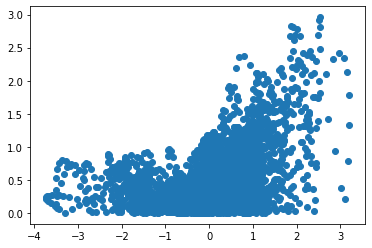

In [261]:
plt.scatter(outlow,np.abs(out25))
print(stats.pearsonr(outlow,np.abs(out25)))

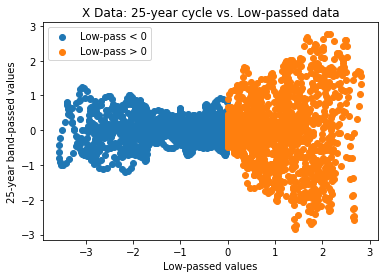

In [50]:
# X data plot of 25 year vs low pass
plt.scatter(outlow[outlow<0],out25[outlow<0],label='Low-pass < 0')
plt.scatter(outlow[outlow>=0],out25[outlow>=0],label='Low-pass > 0')
plt.legend()
plt.title('X Data: 25-year cycle vs. Low-passed data')
plt.xlabel('Low-passed values')
plt.ylabel('25-year band-passed values')
plt.show()

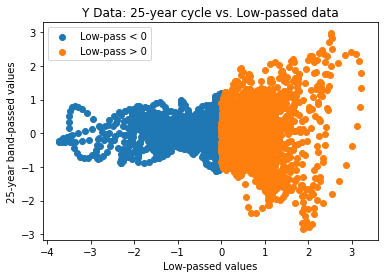

In [95]:
# Y data plot of 25 year vs low pass
plt.scatter(outlow[outlow<0],out25[outlow<0],label='Low-pass < 0')
plt.scatter(outlow[outlow>=0],out25[outlow>=0],label='Low-pass > 0')
plt.legend()
plt.title('Y Data: 25-year cycle vs. Low-passed data')
plt.xlabel('Low-passed values')
plt.ylabel('25-year band-passed values')
plt.show()

In [52]:
# 25 year test of equal variance X
print(stats.levene(out25[outlow>0],out25[outlow<=0]))
print(stats.bartlett(out25[outlow>0],out25[outlow<=0]))

LeveneResult(statistic=429.2559548021016, pvalue=9.210745157456576e-91)
BartlettResult(statistic=1404.1338147722715, pvalue=2.6554813727947855e-307)


In [96]:
# 25 year test of equal variance Y
print(stats.levene(out25[outlow>0],out25[outlow<=0]))
print(stats.bartlett(out25[outlow>0],out25[outlow<=0]))

LeveneResult(statistic=804.8465961232955, pvalue=8.551194596594034e-162)
BartlettResult(statistic=1424.1264756228306, pvalue=1.2015072953974e-311)


In [97]:
# create split sample
outlow1 = outlow[0:len(outlow)//2]
outlow2 = outlow[len(outlow)//2:]
out101 = out10[0:len(outlow)//2]
outl02 = out10[len(outlow)//2:]
out51 = out5[0:len(outlow)//2]
out52 = out5[len(outlow)//2:]
print(outl02)

[ 0.02427577 -0.23475126 -0.39530946 ...  0.00249987  0.00041668
 -0.00138701]


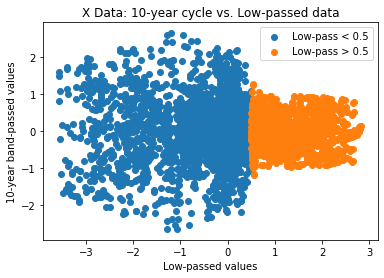

In [85]:
# X data plot of 10 year vs low pass
plt.scatter(outlow[outlow<0.5],out10[outlow<0.5],label='Low-pass < 0.5')
plt.scatter(outlow[outlow>=0.5],out10[outlow>=0.5],label='Low-pass > 0.5')
plt.legend()
plt.title('X Data: 10-year cycle vs. Low-passed data')
plt.xlabel('Low-passed values')
plt.ylabel('10-year band-passed values')
plt.show()

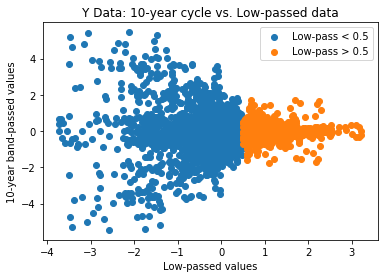

In [98]:
# Y data plot of 10 year vs low pass
plt.scatter(outlow[outlow<0.5],out10[outlow<0.5],label='Low-pass < 0.5')
plt.scatter(outlow[outlow>=0.5],out10[outlow>=0.5],label='Low-pass > 0.5')
plt.legend()
plt.title('Y Data: 10-year cycle vs. Low-passed data')
plt.xlabel('Low-passed values')
plt.ylabel('10-year band-passed values')
plt.show()

In [72]:
# 10 year test of equal variance X
print(stats.levene(out10[outlow>0.5],out10[outlow<=0.5]))
print(stats.bartlett(out10[outlow>0.5],out10[outlow<=0.5]))

LeveneResult(statistic=322.616078220944, pvalue=1.701451204404288e-69)
BartlettResult(statistic=648.6134843981406, pvalue=4.4735416132574765e-143)


In [99]:
# 10 year test of equal variance Y
print(stats.levene(out10[outlow>0.5],out10[outlow<=0.5]))
print(stats.bartlett(out10[outlow>0.5],out10[outlow<=0.5]))

LeveneResult(statistic=186.25294958717333, pvalue=1.6707588331207517e-41)
BartlettResult(statistic=1270.8710483765833, pvalue=2.4177227549988752e-278)


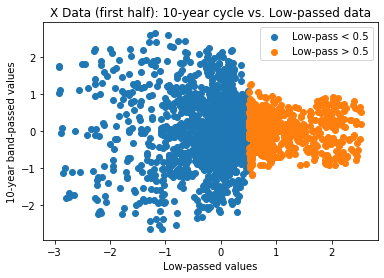

In [83]:
# X data plot of 10 year vs low pass: 1st half
plt.scatter(outlow1[outlow1<0.5],out101[outlow1<0.5],label='Low-pass < 0.5')
plt.scatter(outlow1[outlow1>=0.5],out101[outlow1>=0.5],label='Low-pass > 0.5')
plt.legend()
plt.title('X Data (first half): 10-year cycle vs. Low-passed data')
plt.xlabel('Low-passed values')
plt.ylabel('10-year band-passed values')
plt.show()

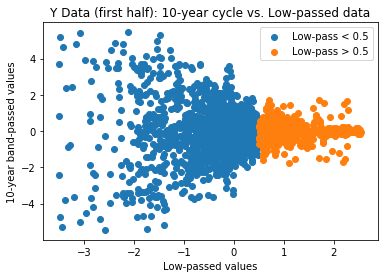

In [100]:
# Y data plot of 10 year vs low pass: 1st half
plt.scatter(outlow1[outlow1<0.5],out101[outlow1<0.5],label='Low-pass < 0.5')
plt.scatter(outlow1[outlow1>=0.5],out101[outlow1>=0.5],label='Low-pass > 0.5')
plt.legend()
plt.title('Y Data (first half): 10-year cycle vs. Low-passed data')
plt.xlabel('Low-passed values')
plt.ylabel('10-year band-passed values')
plt.show()

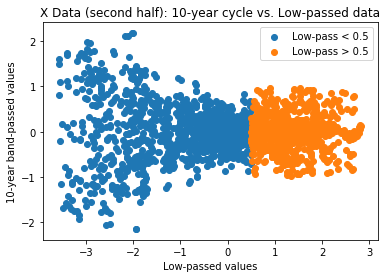

In [84]:
# X data plot of 10 year vs low pass: 2nd half
plt.scatter(outlow2[outlow2<0.5],outl02[outlow2<0.5],label='Low-pass < 0.5')
plt.scatter(outlow2[outlow2>=0.5],outl02[outlow2>=0.5],label='Low-pass > 0.5')
plt.legend()
plt.title('X Data (second half): 10-year cycle vs. Low-passed data')
plt.xlabel('Low-passed values')
plt.ylabel('10-year band-passed values')
plt.show()

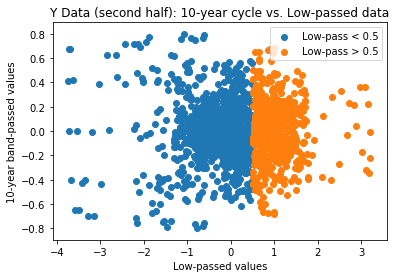

In [101]:
# Y data plot of 10 year vs low pass: 2nd half
plt.scatter(outlow2[outlow2<0.5],outl02[outlow2<0.5],label='Low-pass < 0.5')
plt.scatter(outlow2[outlow2>=0.5],outl02[outlow2>=0.5],label='Low-pass > 0.5')
plt.legend()
plt.title('Y Data (second half): 10-year cycle vs. Low-passed data')
plt.xlabel('Low-passed values')
plt.ylabel('10-year band-passed values')
plt.show()

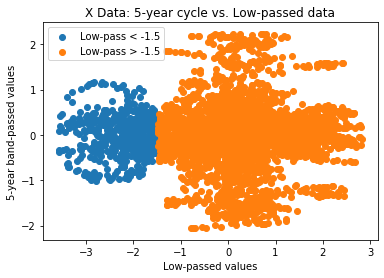

In [81]:
# X data plot of 5 year vs low pass
plt.scatter(outlow[outlow<-1.5],out5[outlow<-1.5],label='Low-pass < -1.5')
plt.scatter(outlow[outlow>=-1.5],out5[outlow>=-1.5],label='Low-pass > -1.5')
plt.legend()
plt.title('X Data: 5-year cycle vs. Low-passed data')
plt.xlabel('Low-passed values')
plt.ylabel('5-year band-passed values')
plt.show()

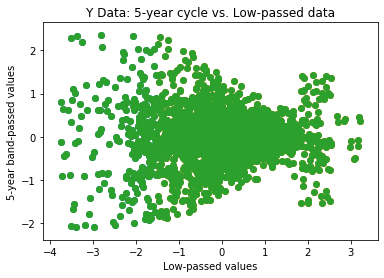

In [110]:
# Y data plot of 5 year vs low pass
plt.scatter(outlow[outlow<-1.5],out5[outlow<-1.5],label='Low-pass < -1.5')
plt.scatter(outlow[outlow>=-1.5],out5[outlow>=-1.5],label='Low-pass > -1.5')
plt.scatter(outlow,out5)
# plt.legend()
plt.title('Y Data: 5-year cycle vs. Low-passed data')
plt.xlabel('Low-passed values')
plt.ylabel('5-year band-passed values')
plt.show()

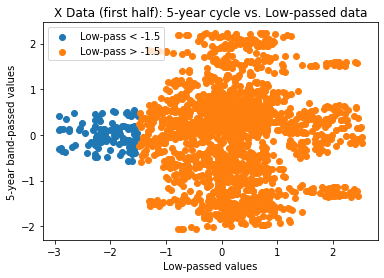

In [80]:
# X data plot of 5 year vs low pass (first half)
plt.scatter(outlow1[outlow1<-1.5],out51[outlow1<-1.5],label='Low-pass < -1.5')
plt.scatter(outlow1[outlow1>=-1.5],out51[outlow1>=-1.5],label='Low-pass > -1.5')
plt.legend()
plt.title('X Data (first half): 5-year cycle vs. Low-passed data')
plt.xlabel('Low-passed values')
plt.ylabel('5-year band-passed values')
plt.show()

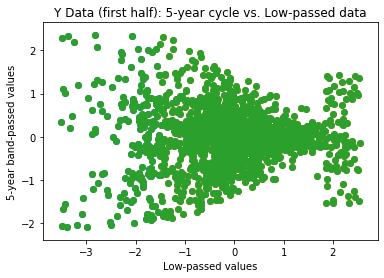

In [108]:
# Y data plot of 5 year vs low pass (first half)
plt.scatter(outlow1[outlow1<-1.5],out51[outlow1<-1.5],label='Low-pass < -1.5')
plt.scatter(outlow1[outlow1>=-1.5],out51[outlow1>=-1.5],label='Low-pass > -1.5')
plt.scatter(outlow1,out51)
# plt.legend()
plt.title('Y Data (first half): 5-year cycle vs. Low-passed data')
plt.xlabel('Low-passed values')
plt.ylabel('5-year band-passed values')
plt.show()

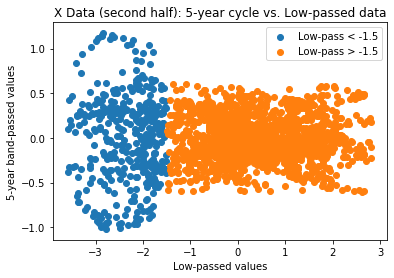

In [82]:
# X data plot of 5 year vs low pass (second half)
plt.scatter(outlow2[outlow2<-1.5],out52[outlow2<-1.5],label='Low-pass < -1.5')
plt.scatter(outlow2[outlow2>=-1.5],out52[outlow2>=-1.5],label='Low-pass > -1.5')
plt.legend()
plt.title('X Data (second half): 5-year cycle vs. Low-passed data')
plt.xlabel('Low-passed values')
plt.ylabel('5-year band-passed values')
plt.show()

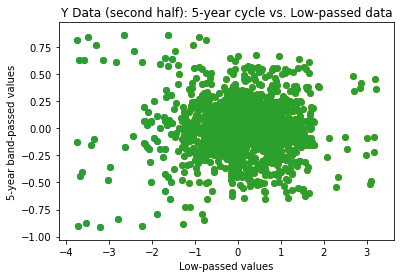

In [109]:
# Y data plot of 5 year vs low pass (second half)
plt.scatter(outlow2[outlow2<-1.5],out52[outlow2<-1.5],label='Low-pass < -1.5')
plt.scatter(outlow2[outlow2>=-1.5],out52[outlow2>=-1.5],label='Low-pass > -1.5')
plt.scatter(outlow2,out52)
# plt.legend()
plt.title('Y Data (second half): 5-year cycle vs. Low-passed data')
plt.xlabel('Low-passed values')
plt.ylabel('5-year band-passed values')
plt.show()

(-0.42511613912599283, 1.8148060702127943e-179)


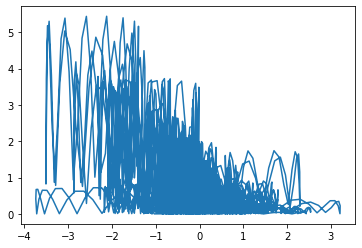

In [462]:
plt.plot(outlow,np.abs(out10))
print(stats.pearsonr(outlow,np.abs(out10)))
# sns.regplot(outlow,np.abs(out10))

(-0.29845671963049725, 4.779989745840125e-85)


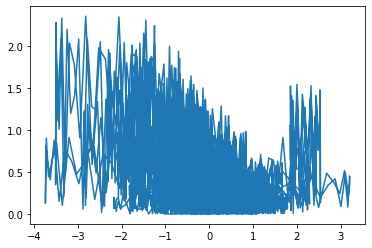

In [445]:
plt.plot(outlow,np.abs(out5))
print(stats.pearsonr(outlow,np.abs(out5)))

In [ ]:
plt.plot(outlow,out25)

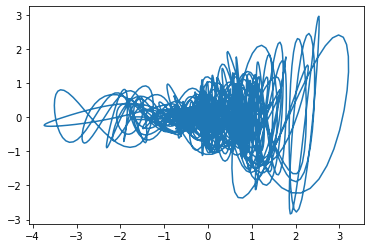

In [429]:
# when outlow is less than 0, the variance is small
plt.plot(outlow,out25)

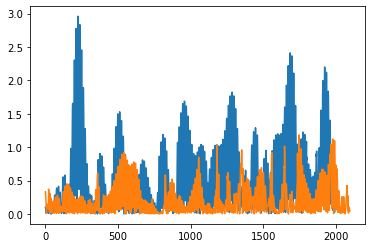

In [433]:
# plt.plot(out25[outlow>0])
# plt.plot(out25[outlow<=0])
plt.plot(np.abs(out25[outlow>0]))
plt.plot(np.abs(out25[outlow<=0]))

In [457]:
stats.f_oneway(out25[outlow>0],out25[outlow<=0])

F_onewayResult(statistic=0.9147411491775665, pvalue=0.3389160458648742)

In [452]:
(out25[outlow>0]).std()

0.8063842856945233

In [453]:
(out25[outlow<=0]).std()

0.33522153694149226

In [455]:
stats.f_oneway(out5[outlow>0],out5[outlow<=0])

F_onewayResult(statistic=0.030205692297420168, pvalue=0.8620329276278631)

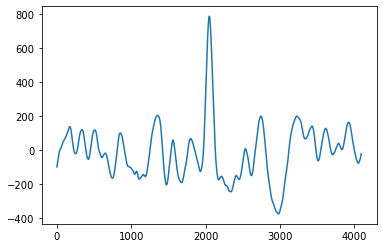

In [467]:
plt.plot(signal.correlate(outlow,np.abs(out25),mode='same'))

(0, 4096)

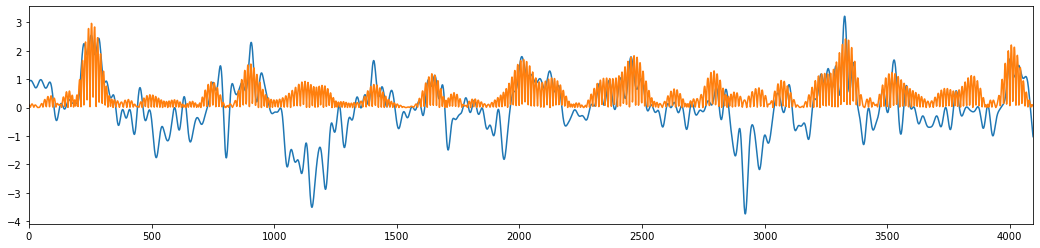

In [479]:
# band pass filter - 25
b, a = signal.butter(7, [wn[0]-bw/nyq, wn[0]+bw/nyq], btype='band')
w25, h25 = signal.freqz(b,a)
out25 = signal.filtfilt(b,a,data)
fig, ax = plt.subplots(figsize=(18,4))
# plt.plot(data)
plt.plot(outlow)
plt.plot(np.abs(out25))
plt.xlim(0,N)

(0, 4096)

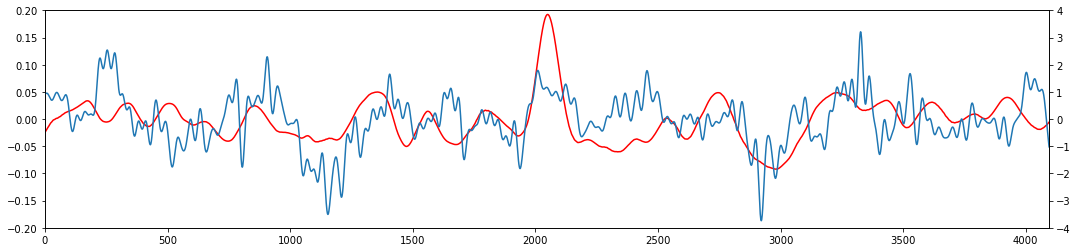

In [478]:
fig, ax = plt.subplots(figsize=(18,4))
plt.ylim(-.2,.2)
plt.plot(signal.correlate(outlow,np.abs(out25),mode='same')/len(outlow),c='r')

ax.twinx()
plt.plot(outlow)
plt.ylim(-4,4)
plt.xlim(0,N)

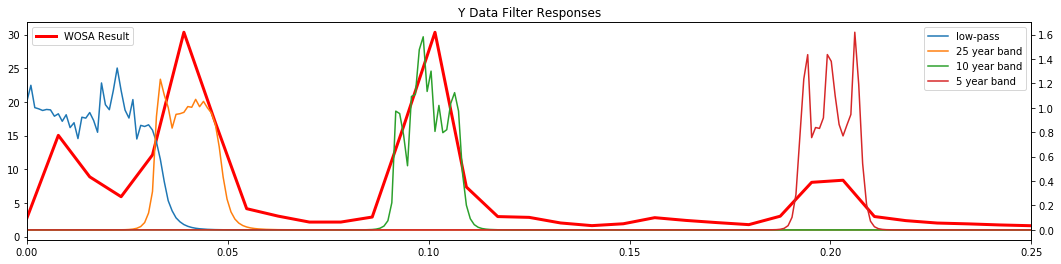

In [55]:
fig, ax = plt.subplots(figsize=(18,4))
plt.plot(freq, Psd, linestyle='-',linewidth=3,c='r',label='WOSA Result')
plt.legend(loc=2)

ax.twinx()
plt.plot(wlow/np.pi/2,np.abs(hlow),label='low-pass')
plt.plot(w25/np.pi/2,np.abs(h25),label='25 year band')
plt.plot(w10/np.pi/2,np.abs(h10),label='10 year band')
plt.plot(w5/np.pi/2,np.abs(h5),label='5 year band')

plt.xlim(0,.25)
plt.xlabel('frequency')


plt.legend()
plt.title('Y Data Filter Responses')
plt.show()

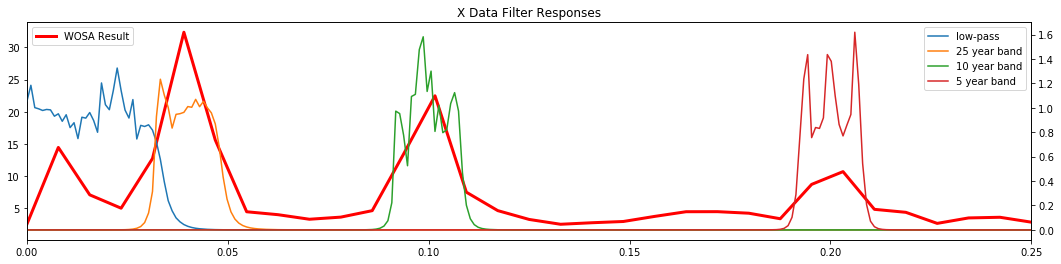

In [70]:
fig, ax = plt.subplots(figsize=(18,4))
plt.plot(freq, Psd, linestyle='-',linewidth=3,c='r',label='WOSA Result')
plt.legend(loc=2)

ax.twinx()
plt.plot(wlow/np.pi/2,np.abs(hlow),label='low-pass')
plt.plot(w25/np.pi/2,np.abs(h25),label='25 year band')
plt.plot(w10/np.pi/2,np.abs(h10),label='10 year band')
plt.plot(w5/np.pi/2,np.abs(h5),label='5 year band')

plt.xlim(0,.25)
plt.xlabel('frequency')


plt.legend()
plt.title('X Data Filter Responses')
plt.show()

In [33]:
len(freq)

65

In [34]:
len(redadj)

65